In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoformerConfig, AutoformerModel  # Updated import from Hugging Face
import statsmodels.api as sm
import joblib
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [26]:
# Load raw dataset
df = pd.read_csv("day_001.csv")

In [27]:
# Extract metadata columns and minute-wise invocation counts
metadata_cols = ['HashOwner', 'HashApp', 'HashFunction', 'Trigger']
time_series_cols = df.columns[len(metadata_cols):] 

In [28]:
# Select a function based on HashFunction and Trigger
target_function = "6c871093253858350d730f80cfbc5109aa2529d9cda37341989ea8854485663e"
target_trigger = "http"
df_function = df[(df['HashFunction'] == target_function) & (df['Trigger'] == target_trigger)]

In [29]:
# Drop metadata columns and reshape to long format
df_function_time_series = df_function[time_series_cols].T.reset_index()
df_function_time_series.columns = ['Minute', 'InvocationCount']
df_function_time_series['Minute'] = df_function_time_series['Minute'].astype(int)

In [30]:
df_function_time_series

,Minute,InvocationCount
0,1,193
1,2,179
2,3,185
3,4,155
4,5,159
...,...,...
1435,1436,768
1436,1437,867
1437,1438,1512
1438,1439,1276


In [31]:
df_function_time_series['Minute'] = pd.to_datetime(df_function_time_series['Minute'], unit='m')
df_function_time_series.set_index('Minute', inplace=True)


In [32]:
# Split into train and test sets
train_size = int(len(df_function_time_series) * 0.8)
train, test = df_function_time_series[:train_size], df_function_time_series[train_size:]


In [33]:
### SARIMA model starts working here

In [34]:
# Fit auto_arima model
auto_arima_model = auto_arima(
    train['InvocationCount'], 
    seasonal=True, 
    m=60,  # Assuming periodicity of 60 minutes
    trace=True, 
    stepwise=True, 
    max_p=3, max_q=3, max_P=2, max_Q=2, 
    max_order=10, 
    n_jobs=-1, 
    maxiter=5  # Limit iterations
)

/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-pac

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[60] intercept   : AIC=19029.321, Time=5.49 sec
 ARIMA(0,1,0)(0,0,0)[60] intercept   : AIC=19271.831, Time=0.03 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[60] intercept   : AIC=19246.677, Time=19.11 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[60] intercept   : AIC=19194.364, Time=7.74 sec
 ARIMA(0,1,0)(0,0,0)[60]             : AIC=19269.831, Time=0.02 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[60] intercept   : AIC=19027.283, Time=9.90 sec
 ARIMA(2,1,2)(0,0,0)[60] intercept   : AIC=19025.394, Time=0.19 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[60] intercept   : AIC=19027.341, Time=10.03 sec
 ARIMA(1,1,2)(0,0,0)[60] intercept   : AIC=19023.770, Time=0.15 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[60] intercept   : AIC=19025.689, Time=8.16 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[60] intercept   : AIC=19025.690, Time=9.70 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[60] intercept   : AIC=19027.706, Time=12.04 sec
 ARIMA(0,1,2)(0,0,0)[60] intercept   : AIC=19031.639, Time=0.15 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[60] intercept   : AIC=19057.623, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[60] intercept   : AIC=19022.196, Time=0.15 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,0)[60] intercept   : AIC=19024.018, Time=9.67 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,1)[60] intercept   : AIC=19024.020, Time=10.54 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,1)[60] intercept   : AIC=19026.034, Time=11.58 sec
 ARIMA(0,1,3)(0,0,0)[60] intercept   : AIC=19020.941, Time=0.20 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,0)[60] intercept   : AIC=19022.854, Time=8.71 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,1)[60] intercept   : AIC=19022.854, Time=10.09 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,1)[60] intercept   : AIC=19024.889, Time=10.48 sec
 ARIMA(0,1,3)(0,0,0)[60]             : AIC=19018.910, Time=0.13 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,0)[60]             : AIC=19020.824, Time=3.45 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,1)[60]             : AIC=19020.823, Time=4.09 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,1)[60]             : AIC=19022.849, Time=5.51 sec
 ARIMA(0,1,2)(0,0,0)[60]             : AIC=19029.635, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[60]             : AIC=19020.192, Time=0.09 sec


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[60]             : AIC=19021.742, Time=0.10 sec

Best model:  ARIMA(0,1,3)(0,0,0)[60]          
Total fit time: 157.784 seconds


In [35]:
# Fit SARIMA model
sarima_model = sm.tsa.statespace.SARIMAX(
    train['InvocationCount'], 
    order=auto_arima_model.order, 
    seasonal_order=auto_arima_model.seasonal_order
).fit()


/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/home/suraj/projects/publish/newenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


In [36]:
# Forecast
forecast = sarima_model.forecast(steps=len(test))

In [37]:
# Evaluate model
mae = mean_absolute_error(test['InvocationCount'], forecast)
mse = mean_squared_error(test['InvocationCount'], forecast)
rmse = np.sqrt(mse)
print(f"SARIMA Model Performance: MAE={mae:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}")


SARIMA Model Performance: MAE=315.1774, MSE=299465.2610, RMSE=547.2342


SARIMA Model Performance: MAE=315.1774, MSE=299465.2610, RMSE=547.2342


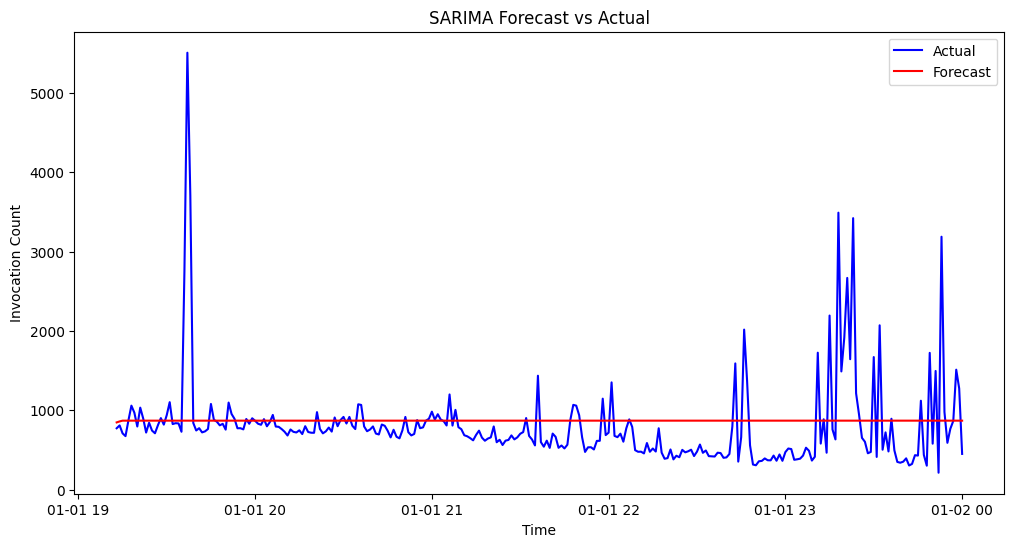

In [38]:
# Evaluate model
mae = mean_absolute_error(test['InvocationCount'], forecast)
mse = mean_squared_error(test['InvocationCount'], forecast)
rmse = np.sqrt(mse)
print(f"SARIMA Model Performance: MAE={mae:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}")

# Plot actual vs forecasted values
plt.figure(figsize=(12,6))
plt.plot(test.index, test['InvocationCount'], label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.xlabel("Time")
plt.ylabel("Invocation Count")
plt.title("SARIMA Forecast vs Actual")
plt.legend()

In [16]:
### Autoformer model code starts from her

In [ ]:
# Create DataLoader
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Prepare data for Autoformer
train_x = torch.tensor(train.index.astype(int).values, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)
train_y = torch.tensor(train['InvocationCount'].values, dtype=torch.float32).unsqueeze(-1)
test_x = torch.tensor(test.index.astype(int).values, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)
test_y = torch.tensor(test['InvocationCount'].values, dtype=torch.float32).unsqueeze(-1)

In [11]:
# Define Autoformer model from Hugging Face Transformers
config = AutoformerConfig(
    prediction_length=10,  # Required parameter for forecasting
    context_length=60,  # Window size of input sequence
    input_size=1,
    d_model=512,
    num_hidden_layers=2,
    num_attention_heads=8,
    dropout_rate=0.05
)
model = AutoformerModel(config)

In [12]:
# Define optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training loop
def train_model(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(
                past_values=y_batch.unsqueeze(-1),  # Ensure correct shape
                past_time_features=x_batch, 
                past_observed_mask=torch.ones_like(y_batch).unsqueeze(-1)  # Ensure correct shape
            ).last_hidden_state
            loss = criterion(output.squeeze(-1), y_batch)  # Align output shape with target
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

In [15]:
# Train the Autoformer model
train_model(model, train_loader, epochs=10)

RuntimeError: expand(torch.FloatTensor{[32, 1, 2, 1]}, size=[-1, 0, -1]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)